In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras import layers, optimizers
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l2
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import re

In [119]:
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [120]:
train_tweets=pd.read_csv('train.csv')
test_tweets=pd.read_csv('test.csv')

In [121]:
train_tweets.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [122]:
train=train_tweets[['text','target']]
test=test_tweets[['id','text']]
train.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [123]:
print('Length of training set:',len(train))
print('Length of test set:',len(test))

Length of training set: 7613
Length of test set: 3263


In [124]:
train['text'].isna().any()

np.False_

In [125]:
train.drop_duplicates(subset='text',inplace=True)
print('Length of training set:',len(train))

Length of training set: 7503


/tmp/ipython-input-1749796273.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop_duplicates(subset='text',inplace=True)


In [126]:
def text_preprocessing(text):
  stop_words=nltk.corpus.stopwords.words('english')

  text=text.str.lower() #lower case words
  text=text.apply(lambda doc: re.sub(r'[^\w\s]+', '', doc)) # remove punctuation
  text=text.apply(lambda doc: ' '.join([word for word in doc.split() if word not in (stop_words)])) # remove stop words
  text=text.apply(lambda doc: re.sub(' +', ' ', doc)) # remove extra white spaces

  return text

In [127]:
train['text']=text_preprocessing(train['text'])
train_tweets['keyword']=text_preprocessing(train_tweets['keyword'].astype(str))

/tmp/ipython-input-476722374.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['text']=text_preprocessing(train['text'])


In [128]:
train.head()

,text,target
0,deeds reason earthquake may allah forgive us,1
1,forest fire near la ronge sask canada,1
2,residents asked shelter place notified officer...,1
3,13000 people receive wildfires evacuation orde...,1
4,got sent photo ruby alaska smoke wildfires pou...,1


Now let us check the distribution of positive and negative tweets

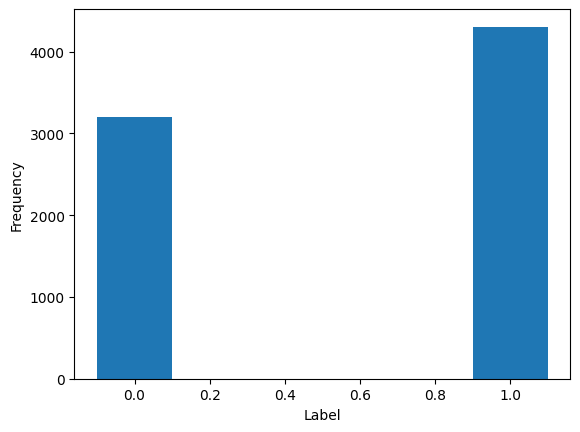

In [129]:
plt.bar(train['target'].unique(),train['target'].value_counts(),width=0.2)
plt.ylabel('Frequency')
plt.xlabel('Label')
plt.show()

We'll now try to generate a word cloud to see the words most frequently used in the training set

In [130]:
corpus=[str(text) for text in train_tweets['keyword']]
corpus=" ".join(corpus)
corpus

'nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock 

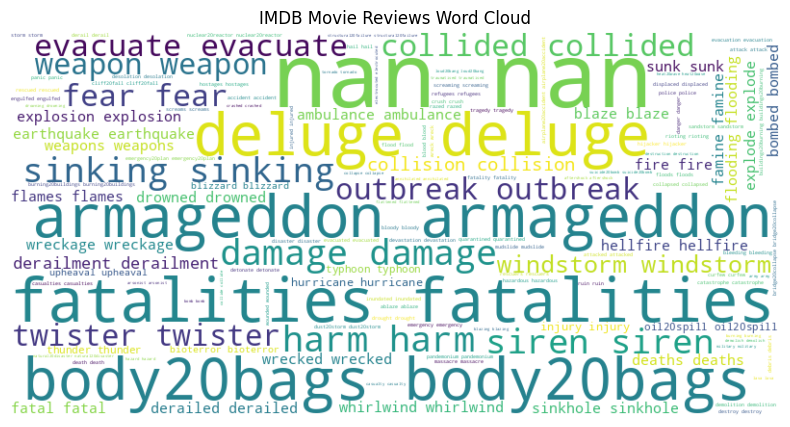

In [131]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(corpus)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("IMDB Movie Reviews Word Cloud")
plt.show()

Now let us analyse the distribution of tweet lengths

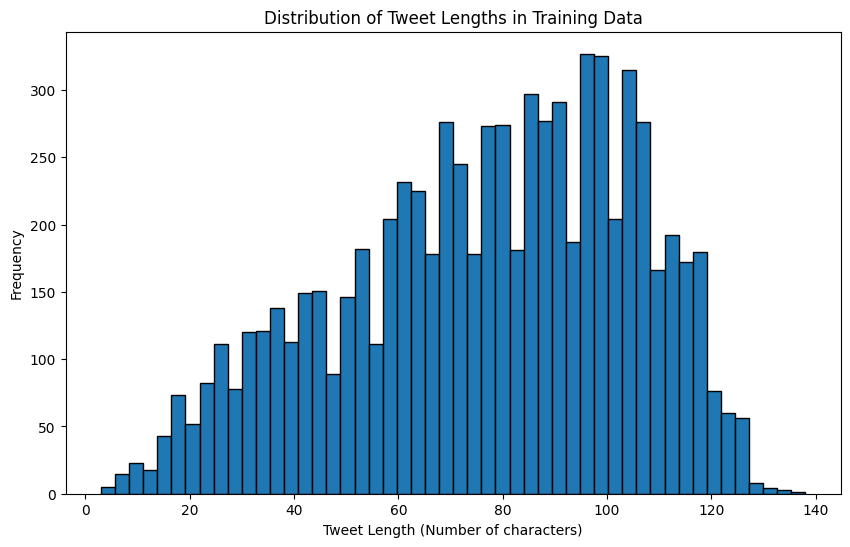

In [132]:
# Calculate the length of each text entry
train_text_lengths = train['text'].apply(len)

# Plot the distribution of text lengths
plt.figure(figsize=(10, 6))
plt.hist(train_text_lengths, bins=50, edgecolor='black')
plt.title('Distribution of Tweet Lengths in Training Data')
plt.xlabel('Tweet Length (Number of characters)')
plt.ylabel('Frequency')
plt.show()

Now let us check additional statistics about the training set

In [133]:
train_text_lengths.describe()

,text
count,7503.000000
mean,76.627349
std,27.745723
min,3.000000
25%,57.500000
50%,80.000000
75%,99.000000
max,138.000000


In [134]:
max_features=2000 #optimized over multiple iterations
max_words=138 #max length of a tweet pulled from describe function above

In [135]:
#we now apply the tokenizor on the text to convert it to numerical format
tokenizer=Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(train['text'])
X=pad_sequences(tokenizer.texts_to_sequences(train['text']),maxlen=max_words)
print(X.shape)

(7503, 138)


In [136]:
#we split training set with a proportion of 85% training and 15% validation
X_train,X_val,y_train,y_val=train_test_split(X,train['target'],test_size=0.15)

In [137]:
print('No. of samples in training set:',len(X_train))
print('No. of samples in validation set:',len(X_val))

No. of samples in training set: 6377
No. of samples in validation set: 1126


In [138]:
X_train.shape

(6377, 138)

In [139]:
model = Sequential()
model.add(Embedding(input_dim=max_features, output_dim=16))
model.add(Dropout(0.4))
model.add(Bidirectional(LSTM(32, return_sequences=False, kernel_regularizer=l2(0.001))))
model.add(Dense(8,activation='relu',kernel_regularizer=l2(0.001)))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))

In [149]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 138, 16)        │        32,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 138, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 64)             │        12,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 135,221 (528.21 KB)

 Trainable params: 45,073 (176.07 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 90,148 (352.14 KB)

In [141]:
callback=EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True) #we save the weights from the epoch with the best validation loss

In [142]:
optimizer = Adam(learning_rate=0.001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [143]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[reduce_lr,callback],
    verbose=1
)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.5606 - loss: 0.7206 - val_accuracy: 0.7700 - val_loss: 0.5820 - learning_rate: 0.0010
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8085 - loss: 0.4837 - val_accuracy: 0.8037 - val_loss: 0.4553 - learning_rate: 0.0010
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8412 - loss: 0.3935 - val_accuracy: 0.7975 - val_loss: 0.4676 - learning_rate: 0.0010
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8587 - loss: 0.3629 - val_accuracy: 0.7957 - val_loss: 0.4745 - learning_rate: 0.0010
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8619 - loss: 0.3469 - val_accuracy: 0.7948 - val_loss: 0.4966 - learning_rate: 0.0010
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8769 - loss: 0.3165 - val_accuracy: 0.7931 - val_loss: 0.5124 - learning_rate: 5.0000e-04
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8690 - loss

In [144]:
train_loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1, len(train_loss) + 1)

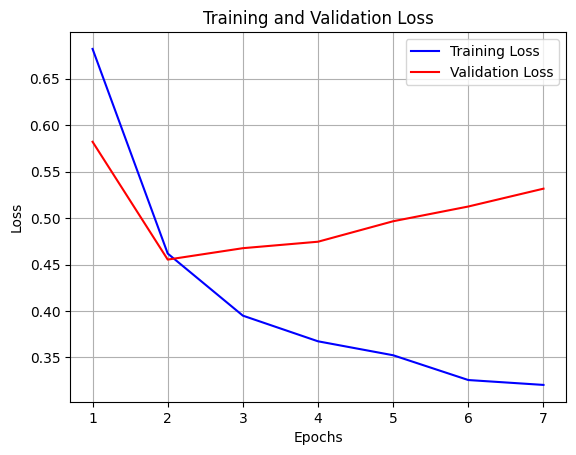

In [145]:
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Now let us apply the same text preprocessing operations to our test set so we can send the input to the model

In [146]:
test['text']=text_preprocessing(test['text'])
y_true=pad_sequences(tokenizer.texts_to_sequences(test['text']),maxlen=max_words)

/tmp/ipython-input-1662475624.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['text']=text_preprocessing(test['text'])


In [147]:
y_pred=model.predict(y_true)
y_pred=(y_pred>0.5).astype(int)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [148]:
df={
    'id':test['id'].tolist(),
    'label':y_pred.tolist()
}
df=pd.DataFrame(df)
df.to_csv('submission.csv',index=False)